In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statistics as sts
import numpy as np
import seaborn as sns
import pickle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def plot_confusion_matrix(matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    matrix.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in
                         matrix.flatten()/np.sum(matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()

### Load Graph Dataset

In [3]:
graph_df = pd.read_csv('https://gitlab.com/viniciusmioto/graph_dataset/-/raw/main/graphs_db.csv')

In [4]:
graph_df.head()

,max_degree,qtd_max_degree,min_degree,qtd_min_degree,avg_degree,density,is_power_law
0,246,1,3,3391,5.997885,0.000705,1
1,176,1,3,1503,5.995263,0.001578,1
2,379,1,5,2385,9.993983,0.001203,1
3,142,1,2,1982,3.997970,0.001015,1
4,398,1,5,2710,9.994828,0.001034,1


In [5]:
graph_df.describe()

,max_degree,qtd_max_degree,min_degree,qtd_min_degree,avg_degree,density,is_power_law
count,3142.000000,3142.000000,3142.000000,3142.00000,3142.000000,3142.000000,3142.000000
mean,1271.745703,1215.934118,37.456079,2975.83832,39.518670,0.105407,0.393380
std,4384.808134,3078.931990,151.577287,8480.16086,151.139218,0.251721,0.488578
min,1.000000,1.000000,0.000000,1.00000,0.320000,0.000010,0.000000
25%,5.000000,1.000000,1.000000,4.00000,2.832228,0.000295,0.000000
50%,40.000000,1.000000,2.000000,442.50000,3.998843,0.000912,0.000000
75%,363.750000,114.750000,3.000000,2386.00000,6.409287,0.094033,1.000000
max,26336.000000,19964.000000,998.000000,225942.00000,998.000000,1.000000,1.000000


### Separate Features (X) and Labels (y) 

In [6]:
X = np.array(graph_df.drop(['is_power_law'], 1))
y = np.array(graph_df['is_power_law'])

### Features Correlation

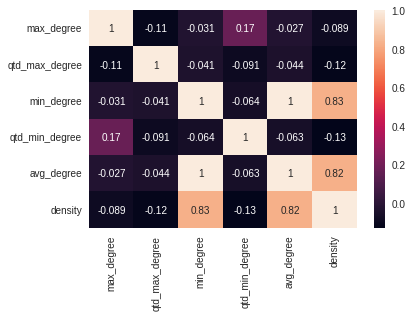

In [7]:
features_df = graph_df.drop(['is_power_law'], 1)
sns.heatmap(features_df.corr(), annot=True)

# Number of Clusters: **2**

### Create and Fit KMeans Model

In [8]:
kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(X)
y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

Apparently, the model switched 1's and 0's. So we switch back again


In [9]:
y_pred_neg = [y_pred[x]*(-1) + 1 for x in range(len(y_pred))]
np.array(y_pred)

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

Real Labels

In [10]:
y

array([1, 1, 1, ..., 1, 1, 1])

### Compare Predictions List
check the predictions that are right

In [11]:
accuracy_list = [1 if y_pred[x] == y[x] else 0 for x in range(len(y))]
np.array(accuracy_list)

array([0, 0, 0, ..., 0, 1, 0])

In [12]:
accuracy_list_neg = [1 if y_pred_neg[x] == y[x] else 0 for x in range(len(y))]
np.array(accuracy_list_neg)

array([1, 1, 1, ..., 1, 0, 1])

### Accuracy

In [13]:
print("Accuracy First Type: ", sum(accuracy_list)/len(accuracy_list))
print("Accuracy Scond Type: ", sum(accuracy_list_neg)/len(accuracy_list_neg))

Accuracy First Type:  0.6460852959898155
Accuracy Scond Type:  0.3539147040101846


percentage of graphs predicted as power-law

In [14]:
print("First Type: Percentage of Power-Law", sum(y_pred)/len(y_pred))
print("Scond Type: Percentage of Power-Law", sum(y_pred_neg)/len(y_pred_neg))

First Type: Percentage of Power-Law 0.03946530872056015
Scond Type: Percentage of Power-Law 0.9605346912794398


real percentage of power-law (dataset)

In [15]:
sum(y)/len(y)

0.39338001273074474

### Predictions
* reais = [0, 0, 0, 1]
* pred = [1, 0, 1, 0]
* pred_neg = [0, 1, 0, 1]

### Accuracy
* acc = [0, 1, 0, 0]
* acc_neg = [1, 0, 1, 1]



### Score

In [16]:
silhouette_score(X, kmeans.labels_)

0.837074325515682

### Confusion Matrix

First Type

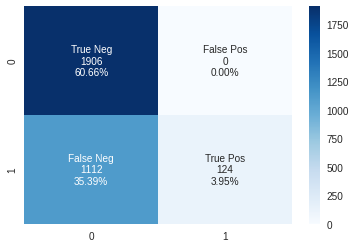

In [17]:
cluster_conf_matrix = confusion_matrix(y, np.array(y_pred))
plot_confusion_matrix(cluster_conf_matrix)

Second Type

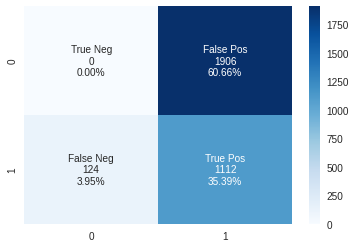

In [18]:
cluster_conf_matrix = confusion_matrix(y, np.array(y_pred_neg))
plot_confusion_matrix(cluster_conf_matrix)

# Finding the Best Number of Clusters

### Silhouette Visualizer

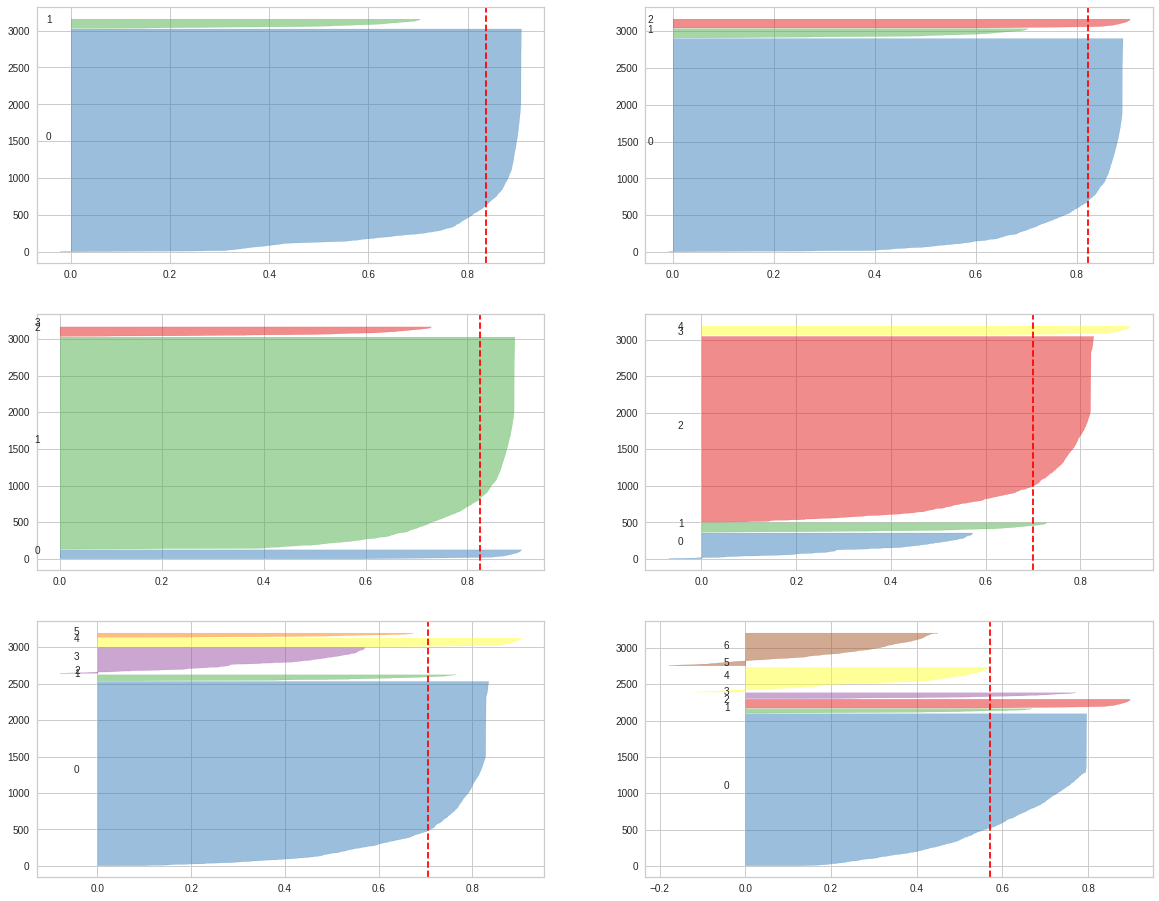

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(20,16))
sscore = [] 
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i)
    q, mod = divmod(i, 2)

    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    sscore.append(silhouette_score(X, km.labels_))

In [20]:
sscore

[0.837074325515682,
 0.8216620209707064,
 0.8242078333859337,
 0.6994312652096545,
 0.705018012459401,
 0.5699256710193676]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


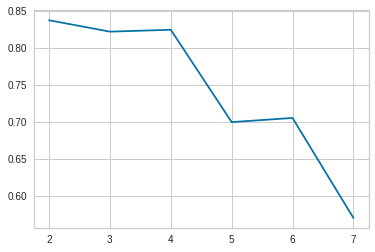

In [21]:
sns.lineplot([2, 3, 4, 5, 6, 7], sscore)
plt.show()

### Param Grid

In [22]:
pipeline = Pipeline([
  ("kmeans", KMeans(n_clusters=10)),
  ("knn", KNeighborsClassifier()),
])
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=10, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [23]:
param_grid = dict(kmeans__n_clusters=range(2, 20))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   13.0s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=10, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=None, tol=0.0001,
                                               verbose=0)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
  

In [24]:
grid_clf.best_params_

{'kmeans__n_clusters': 14}

In [25]:
grid_clf.score(X, y)

0.9894971355824316

# Getting the Graph Type

In [26]:
graph_type_df = pd.read_csv('https://gitlab.com/viniciusmioto/m_learning_graphs/-/raw/master/data/labels.csv')
graph_type_df.head()

,type,is_power_law
0,ba,1
1,ba,1
2,ba,1
3,ba,1
4,ba,1


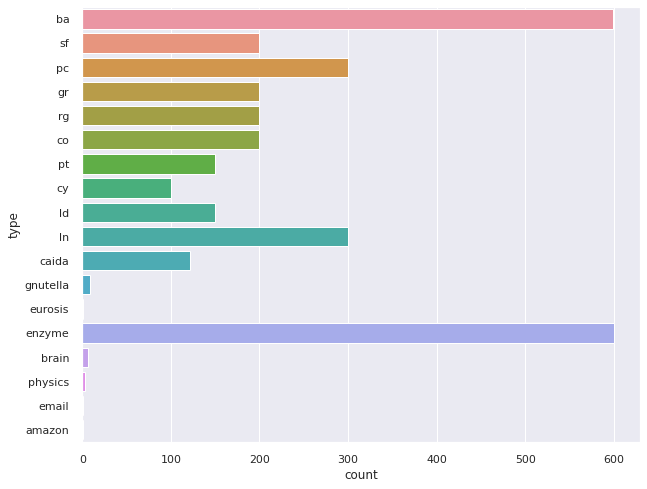

In [27]:
sns.set(rc={"figure.figsize":(10, 8)}) #width=10, height=8
ax = sns.countplot(y="type", data=graph_type_df)

In [28]:
features_df['type'] = graph_type_df['type'].copy()
features_df

,max_degree,qtd_max_degree,min_degree,qtd_min_degree,avg_degree,density,type
0,246,1,3,3391,5.997885,0.000705,ba
1,176,1,3,1503,5.995263,0.001578,ba
2,379,1,5,2385,9.993983,0.001203,ba
3,142,1,2,1982,3.997970,0.001015,ba
4,398,1,5,2710,9.994828,0.001034,ba
...,...,...,...,...,...,...,...
3137,504,1,1,1281,21.106968,0.001124,physics
3138,281,1,1,2373,8.083431,0.000349,physics
3139,65,1,1,2108,5.264352,0.000533,physics
3140,7636,1,1,225942,2.756793,0.000010,email


# How Did the Cluster Separate the Graphs?

### 2 Clusters

In [29]:
cluster_pred_df = features_df.copy()
cluster_pred_df['prediction'] = y_pred
cluster_pred_df

,max_degree,qtd_max_degree,min_degree,qtd_min_degree,avg_degree,density,type,prediction
0,246,1,3,3391,5.997885,0.000705,ba,0
1,176,1,3,1503,5.995263,0.001578,ba,0
2,379,1,5,2385,9.993983,0.001203,ba,0
3,142,1,2,1982,3.997970,0.001015,ba,0
4,398,1,5,2710,9.994828,0.001034,ba,0
...,...,...,...,...,...,...,...,...
3137,504,1,1,1281,21.106968,0.001124,physics,0
3138,281,1,1,2373,8.083431,0.000349,physics,0
3139,65,1,1,2108,5.264352,0.000533,physics,0
3140,7636,1,1,225942,2.756793,0.000010,email,1


In [30]:
cluster_pred_df[['type', 'prediction']].value_counts()

type      prediction
enzyme    0             600
ba        0             599
ln        0             300
sf        0             200
gr        0             200
rg        0             200
co        0             200
pc        0             178
pt        0             150
ld        0             150
pc        1             122
caida     0             122
cy        0             100
gnutella  0               8
brain     0               6
physics   0               3
email     1               1
eurosis   0               1
gnutella  1               1
amazon    0               1
dtype: int64

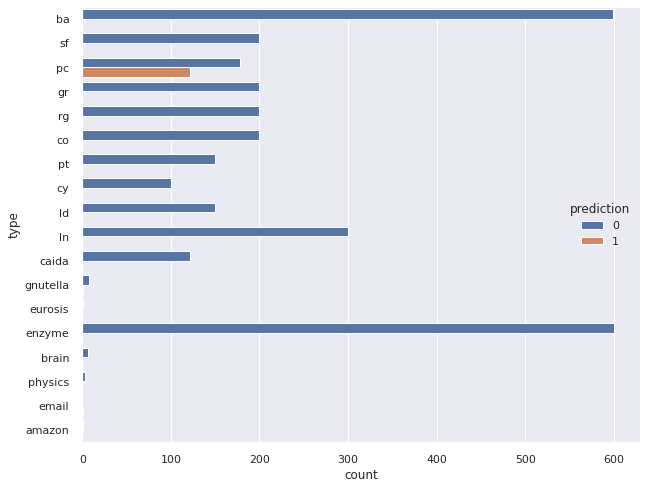

In [31]:
sns.set(rc={"figure.figsize":(10, 8)}) #width=10, height=8
ax = sns.countplot(y="type", hue="prediction", data=cluster_pred_df)

### 3 Clusters

In [32]:
kmeans_3 = KMeans(n_clusters=3)
y_pred_3 = kmeans_3.fit_predict(X)
cluster_pred_3_df = features_df.copy()
cluster_pred_3_df['prediction_3'] = y_pred_3
cluster_pred_3_df

,max_degree,qtd_max_degree,min_degree,qtd_min_degree,avg_degree,density,type,prediction_3
0,246,1,3,3391,5.997885,0.000705,ba,0
1,176,1,3,1503,5.995263,0.001578,ba,0
2,379,1,5,2385,9.993983,0.001203,ba,0
3,142,1,2,1982,3.997970,0.001015,ba,0
4,398,1,5,2710,9.994828,0.001034,ba,0
...,...,...,...,...,...,...,...,...
3137,504,1,1,1281,21.106968,0.001124,physics,0
3138,281,1,1,2373,8.083431,0.000349,physics,0
3139,65,1,1,2108,5.264352,0.000533,physics,0
3140,7636,1,1,225942,2.756793,0.000010,email,1


In [33]:
cluster_pred_3_df[['type', 'prediction_3']].value_counts()

type      prediction_3
enzyme    0               600
ba        0               599
ln        0               300
sf        0               200
gr        0               200
rg        0               200
co        0               200
pc        0               178
pt        0               150
ld        0               150
pc        1               122
caida     2               121
cy        0               100
gnutella  0                 8
brain     0                 6
physics   0                 3
email     1                 1
eurosis   0                 1
gnutella  1                 1
caida     0                 1
amazon    0                 1
dtype: int64

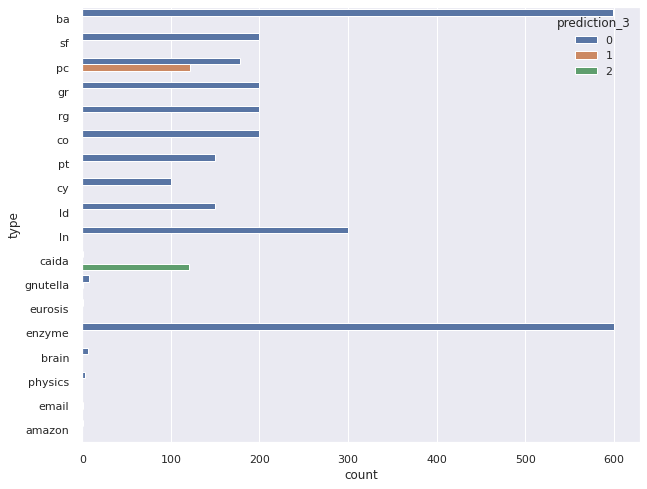

In [34]:
sns.set(rc={"figure.figsize":(10, 8)}) #width=10, height=8
ax = sns.countplot(y="type", hue="prediction_3", data=cluster_pred_3_df)

### 4 Clusters

In [35]:
kmeans_4 = KMeans(n_clusters=4)
y_pred_4 = kmeans_4.fit_predict(X)
y_pred_4

array([0, 0, 0, ..., 0, 3, 0], dtype=int32)

In [36]:
cluster_pred_4_df = features_df.copy()
cluster_pred_4_df['prediction_4'] = y_pred_4
cluster_pred_4_df

,max_degree,qtd_max_degree,min_degree,qtd_min_degree,avg_degree,density,type,prediction_4
0,246,1,3,3391,5.997885,0.000705,ba,0
1,176,1,3,1503,5.995263,0.001578,ba,0
2,379,1,5,2385,9.993983,0.001203,ba,0
3,142,1,2,1982,3.997970,0.001015,ba,0
4,398,1,5,2710,9.994828,0.001034,ba,0
...,...,...,...,...,...,...,...,...
3137,504,1,1,1281,21.106968,0.001124,physics,0
3138,281,1,1,2373,8.083431,0.000349,physics,0
3139,65,1,1,2108,5.264352,0.000533,physics,0
3140,7636,1,1,225942,2.756793,0.000010,email,3


In [37]:
cluster_pred_4_df[['type', 'prediction_4']].value_counts()

type      prediction_4
enzyme    0               600
ba        0               599
ln        0               300
sf        0               200
gr        0               200
rg        0               200
co        0               200
pc        0               172
pt        0               150
ld        0               150
pc        1               128
caida     2               121
cy        0               100
gnutella  0                 8
brain     0                 6
physics   0                 3
email     3                 1
eurosis   0                 1
gnutella  1                 1
caida     0                 1
amazon    0                 1
dtype: int64

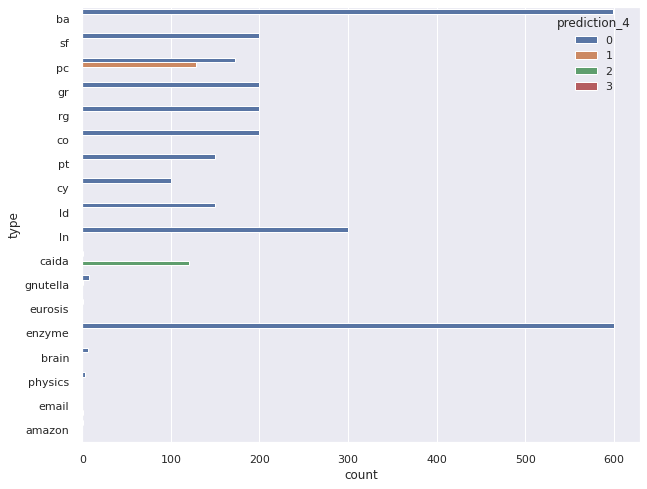

In [38]:
sns.set(rc={"figure.figsize":(10, 8)}) #width=10, height=8
ax = sns.countplot(y="type", hue="prediction_4", data=cluster_pred_4_df)